# Time Series Forecasting

In this tutorial, we will go through how to forecast with `GenTS` models and datasets. 

## Problem setting
Given a look back window, $\mathbf{x}_{\text{obs}} \in \mathbb{R}^{L \times D}$, we are interested in the conditional distribution, i.e. $p(\mathbf{x}_{\text{target}} \mid \mathbf{x}_{\text{obs}})$. From this distribution, we can sample possible forecasts $\hat{\mathbf{x}}_{\text{target}} \in \mathbb{R}^{T \times D}$

## Implementation
### 1. import modules

In [1]:
import torch
from gents.dataset import Spiral2D
from gents.model import VanillaDDPM
from gents.evaluation import predict_visual, crps
from lightning import Trainer

/home/wcx/anaconda3/envs/gents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


### 2. setup datamodule and model
Here, we set $L=T=32$ for an example. Note that `condition='predict'` and `obs_len=32` is also required for datamodule and model for setup.

In [2]:
dm = Spiral2D(
    seq_len=32,
    obs_len=32,
    batch_size=64,
    data_dir="../data",
    condition="predict",
)
model = VanillaDDPM(
    obs_len=dm.obs_len, seq_len=dm.seq_len, seq_dim=dm.seq_dim, condition="predict"
)

### 3. setup training
Utilizing `lightning`/`pytorch-lightning`, one can easily set:
- GPU devices
- Training epochs/steps
- Callbacks
- etc..

In [3]:
trainer = Trainer(max_epochs=10, devices=[0], enable_progress_bar=False)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type | Params | Mode 
------------------------------------------
0 | backbone | DiT  | 1.2 M  | train
------------------------------------------
1.2 M     Trainable params
512       Non-trainable params
1.2 M     Total params
4.734     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=10` reached.


### 4. forecasting on the test set
Here `n_sample=10` means we sample $\hat{\mathbf{x}}_{\text{target}} \in \mathbb{R}^{T \times D}$ 10 times. The tensor shape of `gen_data` is `[batch_size, T, D, n_sample]`

In [4]:
# testing
dm.setup("test")
real_data = torch.cat([batch["seq"] for batch in dm.test_dataloader()])
cond_data = torch.cat([batch["c"] for batch in dm.test_dataloader()])

gen_data = model.sample(
    n_sample=10,
    condition=cond_data,
)

### 5. Evaluation
`GenTS` provides a plot function for visualizing probabilistic forecasts, as well as some metrics like CRPS to quantitative evaluation

np.float64(0.011574582569024659)

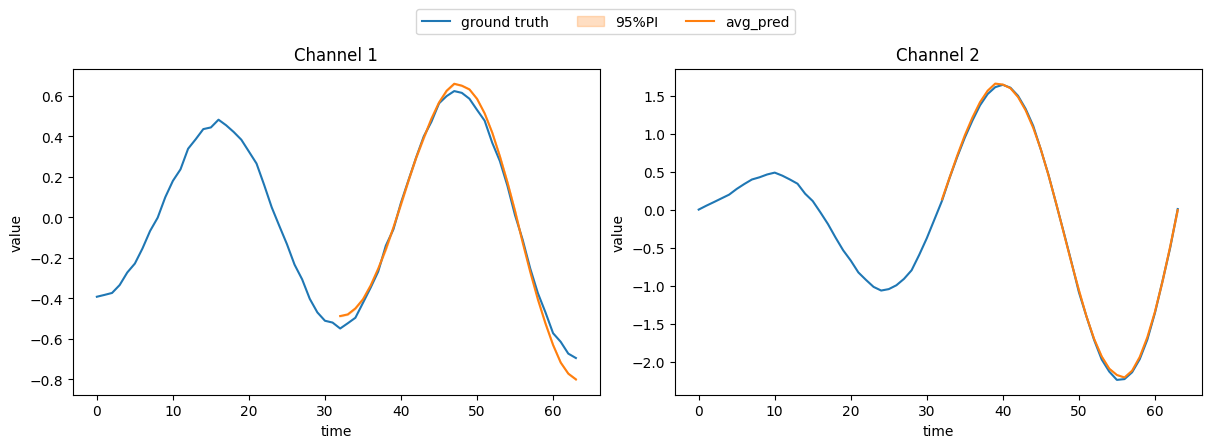

In [5]:
predict_visual(
    real_data=real_data,
    gen_data=gen_data,
    data_mask=torch.ones_like(real_data).bool(),
    # uncomment the following line to save the plot
    # save_root='./predict.png'
)
crps(real_data[:,dm.obs_len:], gen_data)